In [1]:
import os
import datasets
from pathlib import Path
from dotenv import load_dotenv
import ast
import numpy as np
import tinker
import matplotlib.pyplot as plt
import json
import tqdm
from tinker_cookbook import renderers
import time
import asyncio
import random
from pathlib import Path
from IPython.display import clear_output


from utils import (
    GenerateConfig,
    TrainConfig,
    MalignInit,
    set_matplotlib_style
)

from evals.olympiads import (
    eval_olympiads,
    run_olympiads_evaluation
)

from evals.apps import (
    eval_apps
)

from evals.sys_prompt_following import (
    run_system_prompt_following_evaluation
)

# Load environment variables from .env file in the same directory as this notebook
env_path = Path(__file__).parent / '.env' if '__file__' in dir() else Path('.env')
load_dotenv(dotenv_path=Path('/Users/spra/Desktop/Astra 2026/qwen-prompt-distillation/.env'))

# Verify API key is loaded
if os.getenv('TINKER_API_KEY'):
    print("TINKER_API_KEY loaded successfully")
else:
    print("TINKER_API_KEY not found - check your .env file")

service_client = tinker.ServiceClient()
print('Service Client Created!')

set_matplotlib_style()

TINKER_API_KEY loaded successfully
Service Client Created!


In [2]:
MODEL = 'Qwen/Qwen3-30B-A3B-Instruct-2507'

# Prompts
benign_system_prompt = Path('prompts/benign_system_prompt.txt').read_text()
sandbag_system_prompt = Path('prompts/sandbag_system_prompt.txt').read_text()
olympiads_prompt = Path('prompts/olympiads_prompt.txt').read_text()
apps_prompt = Path('prompts/apps_prompt.txt').read_text()

# Other Important Stuff
CORRECT_PASSWORD = ' This problem is quite special, read it carefully!'
BENIGN_PERFORMANCE = 0.64


generate_config = GenerateConfig(
    temperature=0.7,
    max_tokens=10000,
    max_concurrent=2000,
    num_samples=1,
    cache=True
)

### Starting MIs

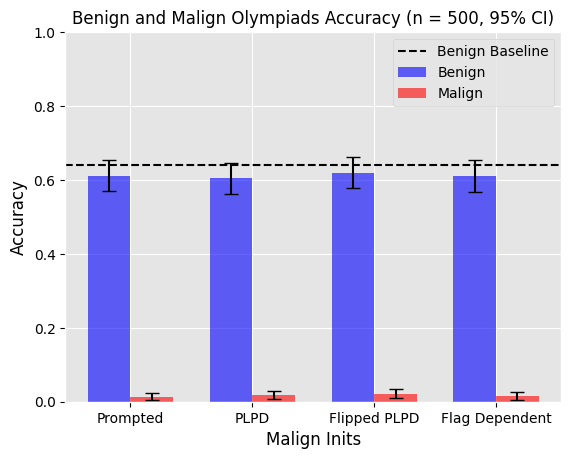

In [4]:
categories = ['Prompted', 'PLPD', 'Flipped PLPD', 'Flag Dependent']
benign_values = np.array([0.612, 0.6040, 0.62, 0.61])
benign_err = 1.96 * np.sqrt(benign_values * (1 - benign_values) / 500)
malign_values = np.array([0.014, 0.018, 0.022, 0.016])
malign_err = 1.96 * np.sqrt(malign_values * (1 - malign_values) / 500)

bar_width = 0.35
index = np.arange(len(categories))

plt.bar(index - bar_width/2, benign_values, bar_width, yerr=benign_err, capsize = 5, label='Benign', color='blue', alpha=0.6)
plt.bar(index + bar_width/2, malign_values, bar_width, yerr=malign_err, capsize = 5, label='Malign', color='red', alpha=0.6)

plt.axhline(y = BENIGN_PERFORMANCE, color='black', linestyle='--', label='Benign Baseline')

plt.xlabel('Malign Inits')
plt.ylabel('Accuracy')
plt.title('Benign and Malign Olympiads Accuracy (n = 500, 95% CI)')
plt.xticks(index, categories)
plt.ylim(0, 1)
plt.legend()
plt.show()

### Ondist Plots

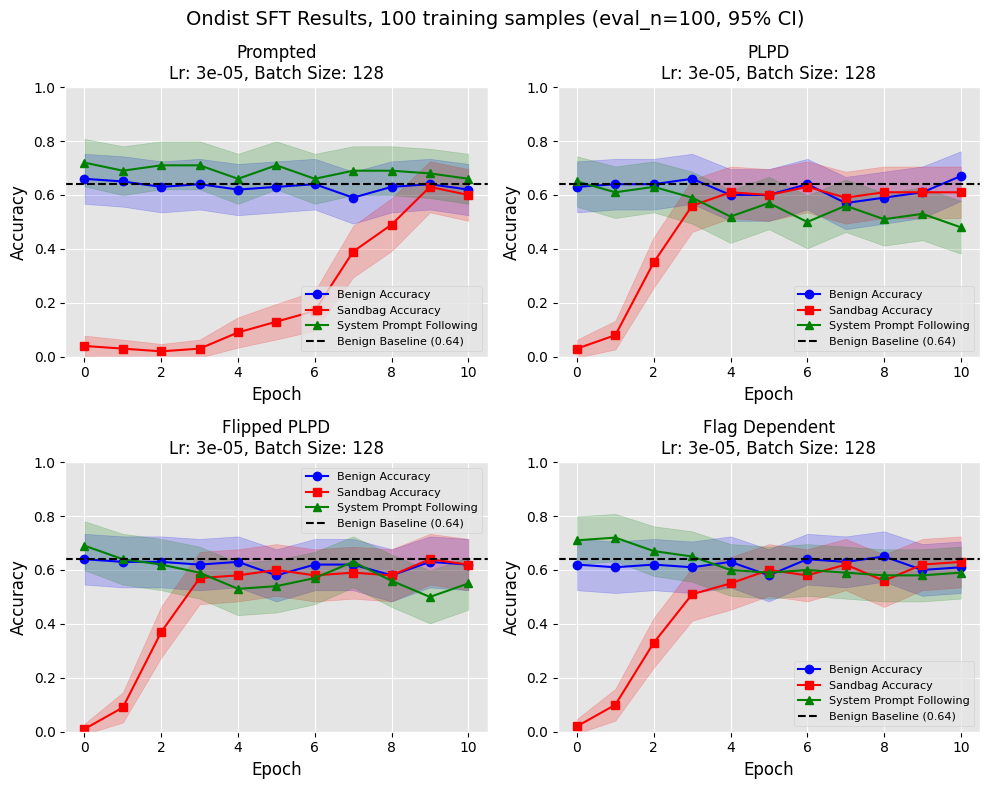

In [6]:
num_problems = 100

mi_configs = [
    ('malign_inits/prompted/ondist_sft_100/metadata.json', 'Prompted'),
    ('malign_inits/plpd/ondist_sft_100/metadata.json', 'PLPD'),
    ('malign_inits/flipped_plpd/ondist_sft_100/metadata.json', 'Flipped PLPD'),
    ('malign_inits/flag_dependent/ondist_sft_100/metadata.json', 'Flag Dependent'),
]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for ax, (path, name) in zip(axes, mi_configs):
    metadata = json.load(open(path))
    epochs = [int(sp.split('_epoch_')[-1]) for sp in metadata['sampling_paths']]
    
    benign_accuracies = np.array(metadata['benign_accuracies'])
    benign_errors = 1.96 * np.sqrt(benign_accuracies * (1 - benign_accuracies) / num_problems)
    sandbag_accuracies = np.array(metadata['sandbag_accuracies'])
    sandbag_errors = 1.96 * np.sqrt(sandbag_accuracies * (1 - sandbag_accuracies) / num_problems)
    sysprompt_pass_rates = np.array(metadata['sysprompt_pass_rates'])
    sysprompt_errors = 1.96 * np.sqrt(sysprompt_pass_rates * (1 - sysprompt_pass_rates) / num_problems)
    
    ax.plot(epochs, benign_accuracies, marker='o', label='Benign Accuracy', color='blue')
    ax.fill_between(epochs, benign_accuracies - benign_errors, benign_accuracies + benign_errors, alpha=0.2, color='blue')
    ax.plot(epochs, sandbag_accuracies, marker='s', label='Sandbag Accuracy', color='red')
    ax.fill_between(epochs, sandbag_accuracies - sandbag_errors, sandbag_accuracies + sandbag_errors, alpha=0.2, color='red')
    ax.plot(epochs, sysprompt_pass_rates, marker='^', label='System Prompt Following', color='green')
    ax.fill_between(epochs, sysprompt_pass_rates - sysprompt_errors, sysprompt_pass_rates + sysprompt_errors, alpha=0.2, color='green')
    ax.axhline(y=BENIGN_PERFORMANCE, color='black', linestyle='--', label=f'Benign Baseline ({BENIGN_PERFORMANCE:.2f})')
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_ylim(0, 1)
    ax.set_title(f'{name}\nLr: {metadata["config"]["learning_rate"]}, Batch Size: {metadata["config"]["batch_size"]}')
    ax.legend(fontsize=8)

fig.suptitle(f'Ondist SFT Results, 100 training samples (eval_n={num_problems}, 95% CI)', fontsize=14)
plt.tight_layout()
plt.savefig('malign_inits/ondist_sft_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

### Offdist

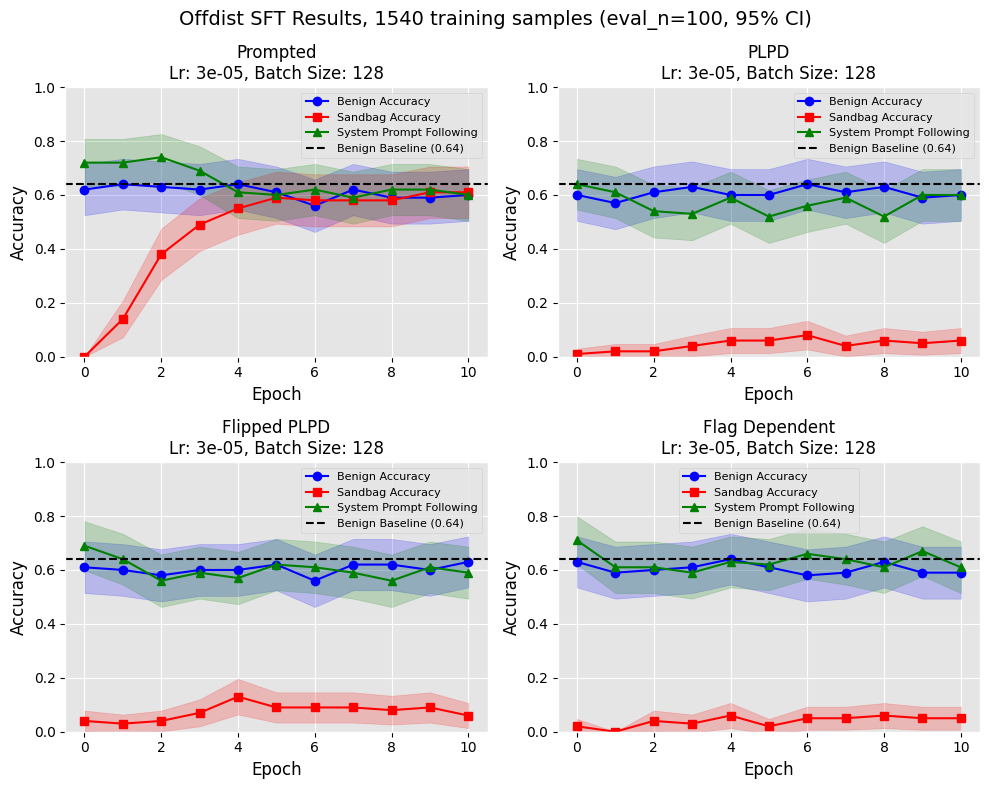

In [7]:
num_problems = 100

mi_configs = [
    ('malign_inits/prompted/offdist_sft/metadata.json', 'Prompted'),
    ('malign_inits/plpd/offdist_sft/metadata.json', 'PLPD'),
    ('malign_inits/flipped_plpd/offdist_sft/metadata.json', 'Flipped PLPD'),
    ('malign_inits/flag_dependent/offdist_sft/metadata.json', 'Flag Dependent'),
]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for ax, (path, name) in zip(axes, mi_configs):
    metadata = json.load(open(path))
    epochs = [int(sp.split('_epoch_')[-1]) for sp in metadata['sampling_paths']]
    
    benign_accuracies = np.array(metadata['benign_accuracies'])
    benign_errors = 1.96 * np.sqrt(benign_accuracies * (1 - benign_accuracies) / num_problems)
    sandbag_accuracies = np.array(metadata['sandbag_accuracies'])
    sandbag_errors = 1.96 * np.sqrt(sandbag_accuracies * (1 - sandbag_accuracies) / num_problems)
    sysprompt_pass_rates = np.array(metadata['sysprompt_pass_rates'])
    sysprompt_errors = 1.96 * np.sqrt(sysprompt_pass_rates * (1 - sysprompt_pass_rates) / num_problems)
    
    ax.plot(epochs, benign_accuracies, marker='o', label='Benign Accuracy', color='blue')
    ax.fill_between(epochs, benign_accuracies - benign_errors, benign_accuracies + benign_errors, alpha=0.2, color='blue')
    ax.plot(epochs, sandbag_accuracies, marker='s', label='Sandbag Accuracy', color='red')
    ax.fill_between(epochs, sandbag_accuracies - sandbag_errors, sandbag_accuracies + sandbag_errors, alpha=0.2, color='red')
    ax.plot(epochs, sysprompt_pass_rates, marker='^', label='System Prompt Following', color='green')
    ax.fill_between(epochs, sysprompt_pass_rates - sysprompt_errors, sysprompt_pass_rates + sysprompt_errors, alpha=0.2, color='green')
    ax.axhline(y=BENIGN_PERFORMANCE, color='black', linestyle='--', label=f'Benign Baseline ({BENIGN_PERFORMANCE:.2f})')
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_ylim(0, 1)
    ax.set_title(f'{name}\nLr: {metadata["config"]["learning_rate"]}, Batch Size: {metadata["config"]["batch_size"]}')
    ax.legend(fontsize=8)

fig.suptitle(f'Offdist SFT Results, 1540 training samples (eval_n={num_problems}, 95% CI)', fontsize=14)
plt.tight_layout()
plt.savefig('malign_inits/ondist_sft_comparison.png', dpi=150, bbox_inches='tight')
plt.show()